<a href="https://colab.research.google.com/github/MaschinenNah/ml_utils_develop_and_test/blob/main/ml_utils_show_develop_and_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Package ml_utils laden und importieren

In [2]:
!git clone https://github.com/MaschinenNah/ml_utils
from ml_utils import load
from ml_utils import convert
from ml_utils import show

Cloning into 'ml_utils'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 44 (delta 11), reused 34 (delta 6), pack-reused 0
Unpacking objects: 100% (44/44), done.


## Anzeige von Batches, einfach


### Generator zu Testzwecken

In [3]:
zip_url = "https://github.com/MaschinenNah/ml_utils_develop_and_test/raw/main/ml_utils_show_demo_data_01.zip"
load.load_and_unzip_from_url(zip_url)

In [4]:
from tensorflow.keras.utils import Sequence
import numpy as np
from PIL import Image
import os
import random

class ImageGenerator(Sequence):

  def __init__(self, dir_, shape, batch_size=25):
    filenames = os.listdir(dir_)
    self.len = int(len(filenames)/batch_size)
    self.shape = shape
    self.batch_size = batch_size
    self.file_paths = load.all_abs_paths_in_dir(dir_)
    random.shuffle(self.file_paths)

  def __len__(self):
    return self.len

  def __getitem__(self, index):
    if index >= self.len:
      raise IndexError("list index out of range")
    else:
      file_paths = self.file_paths[index*self.batch_size:(index+1)*self.batch_size]
      batch_x = np.empty((self.batch_size,) + (self.shape), "float32")
      batch_y = np.empty((self.batch_size,) + (self.shape), "float32")
      for idx, file_path in enumerate(file_paths):
        img_as_array = load.img_path_to_np_array(file_path)
        batch_x[idx] = img_as_array
        batch_y[idx] = np.fliplr(img_as_array)
      return batch_x, batch_y

### show_images_from_np_array

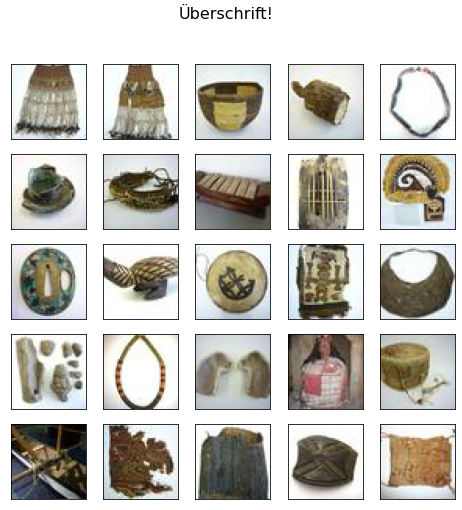

In [5]:
import math
from matplotlib import pyplot as plt

def show_images_from_np_array(np_array, title, width=8):
  fig = plt.figure(figsize=(width, width))
  x_size = np_array.shape[0]
  x_size_sqrt = math.ceil(math.sqrt(x_size))
  if (len(np_array.shape)) == 3:
    cmap = "gray"
  else:
    cmap = "viridis"

  for x in range(x_size):
    plt.subplot(x_size_sqrt, x_size_sqrt, x+1)
    plt.xticks(())
    plt.yticks(())
    plt.imshow(np_array[x], cmap=cmap)
  
  fig.suptitle(title, fontsize=16)

gen = ImageGenerator("/content/data/img_train", (48, 48, 3), 25)
show_images_from_np_array(gen[0][0], "Überschrift!")

### show_batch

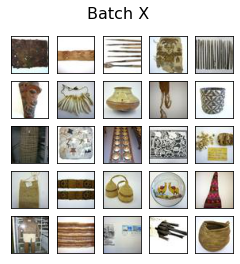

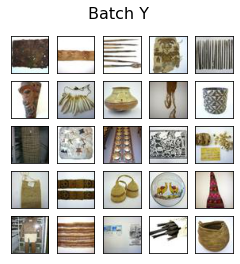

In [ ]:
def show_batch(batch, width=8):
  show_images_from_np_array(batch[0], "Batch X", width)
  show_images_from_np_array(batch[1], "Batch Y", width)

gen = ImageGenerator("/content/data/img_train", (48, 48, 3), 25)
show_batch(gen[0], 4)

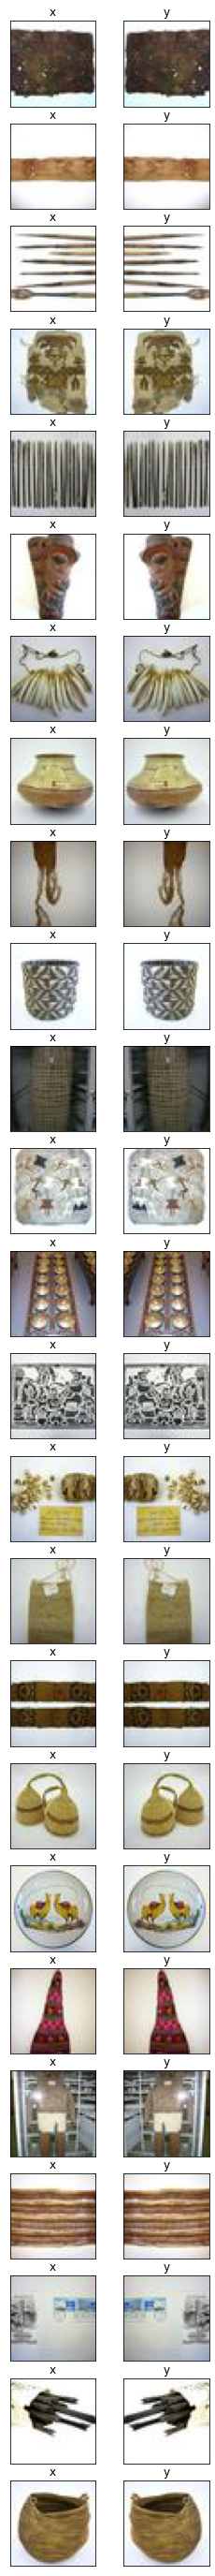

In [ ]:
def show_and_compare_batch(batch, width=4):
  batch_size = batch[0].shape[0]
  fig = plt.figure(figsize=(width, width/2*batch_size))
  for x in range(batch_size):
    plt.subplot(batch_size, 2, 2 * x+1)
    plt.xticks(())
    plt.yticks(())
    plt.imshow(batch[0][x])
    plt.title("x")
    plt.subplot(batch_size, 2, 2 * x+2)
    plt.xticks(())
    plt.yticks(())
    plt.imshow(batch[1][x])
    plt.title("y")

show_and_compare_batch(gen[0], 4)

## Anzeige von Batches für Frame Predicion



### Generator zu Testzwecken

In [6]:
zip_url = "https://github.com/MaschinenNah/ml_utils_develop_and_test/raw/main/ml_utils_show_demo_data_01.zip"
load.load_and_unzip_from_url(zip_url)

In [30]:
from tensorflow.keras.utils import Sequence
import numpy as np
from PIL import Image
import os
import random


class FramePredictionGenerator(Sequence):

  def __init__(self, dir_, frame_shape, n_frames, batch_size=25):
    random.seed(0)

    self.frame_shape = frame_shape
    self.n_frames = n_frames
    self.batch_size = batch_size    
    scene_dir_paths =  load.all_abs_paths_in_dir(dir_)
    self.all_examples = []
    
    for scene_dir_path in scene_dir_paths:
      all_frame_paths_in_scene = load.all_abs_paths_in_dir(scene_dir_path)
      list.sort(all_frame_paths_in_scene)

      number_of_frames = len(all_frame_paths_in_scene)
      number_of_examples = number_of_frames - self.n_frames

      for example_index in range(number_of_examples):
        example = []
        for frame_index in range(self.n_frames+1):
          index = example_index + frame_index
          example.append(all_frame_paths_in_scene[index])
        self.all_examples.append(example)
      
      random.shuffle(self.all_examples)  

  def __len__(self):
    return len(self.all_examples)

  def __getitem__(self, batch_index):
    if batch_index >= len(self):
      raise IndexError("batch index out of range")
    else:
      batch_x, batch_y = self._get_empty_batches()
      start = int(batch_index * self.batch_size)
      stop = int((batch_index + 1) * self.batch_size)
      selection = self.all_examples[start:stop]
      
      for example_idx, example in enumerate(selection):
        for frame_idx, img_path in enumerate(example[:-1]):
          img_as_array_rgb = load.img_path_to_np_array(img_path)
          img_as_array_grey = convert.rgb_to_grayscale(img_as_array_rgb) 
          batch_x[example_idx, frame_idx] = img_as_array_grey
        img_path = example[-1]
        img_as_array_rgb = load.img_path_to_np_array(img_path)
        img_as_array_grey = convert.rgb_to_grayscale(img_as_array_rgb)
        batch_y[example_idx] = img_as_array_grey

    return batch_x, batch_y

  def _get_empty_batches(self):
    empty_batch_x = np.empty((self.batch_size,) + (self.n_frames,) + (self.frame_shape), "float32")
    empty_batch_y = np.empty((self.batch_size,) + (self.frame_shape), "float32")
    return empty_batch_x, empty_batch_y

### neu


In [31]:
frame_pred_gen = FramePredictionGenerator("/content/data/scenes", (48, 48), 8, 8)

In [32]:
batch = frame_pred_gen[0]

In [33]:
batch[1].shape

(8, 48, 48)

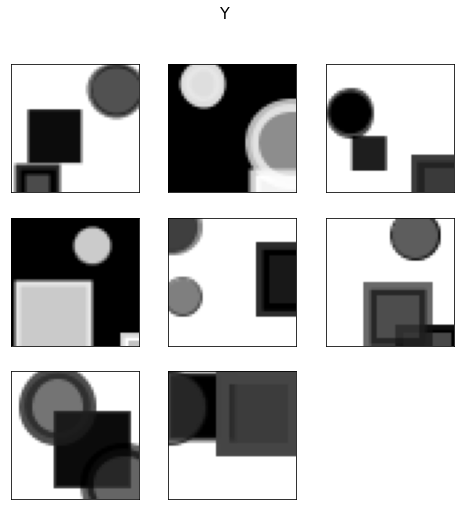

In [34]:
show_images_from_np_array(batch[1], "Y")

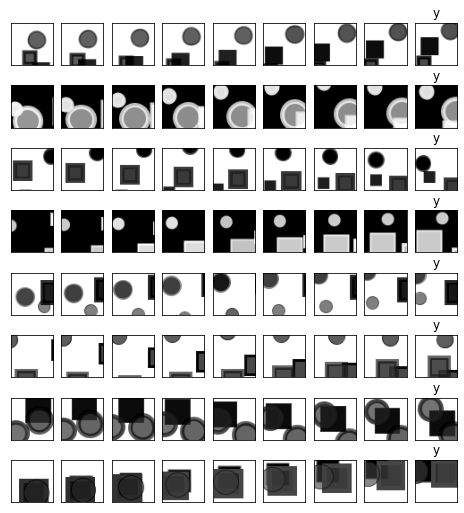

In [35]:
def show_frame_prediction_batch(batch):
  n_rows = batch[0].shape[0]
  n_columns = batch[0][0].shape[0]+1

  fig = plt.figure(figsize=(n_rows, n_columns))
  
  for row in range(n_rows):
    for column in range(n_columns-1):
      subplot_idx = (n_columns * row) + column + 1
      plt.subplot(n_rows, n_columns, subplot_idx)
      plt.xticks(())
      plt.yticks(())
      img = batch[0][row][column]
      plt.imshow(img, cmap="gray")
    subplot_idx = (n_columns * row) + n_rows + 1
    plt.subplot(n_rows, n_columns, subplot_idx)
    img = batch[1][row]
    plt.imshow(img, cmap="gray")
    plt.title("y")
    plt.xticks(())
    plt.yticks(())
  
show_frame_prediction_batch(batch)